In [ ]:
# !pip install python-dotenv

### 라이브러리 & 설정

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
from pathlib import Path
from dotenv import load_dotenv
import pandas as pd
import numpy as np

# 경로 설정
BASE_DIR = Path.cwd()
ENV_PATH = BASE_DIR / ".env"
load_dotenv(dotenv_path=ENV_PATH)

DATA_DIR = Path(os.getenv("DATA_DIR")).resolve()
DATA_PATH = DATA_DIR / "training" / "final" / "travel_ml.csv"
VAL_DATA_PATH = DATA_DIR / "validation" / "final" / "travel_ml.csv"

# 학습/평가 데이터
train = pd.read_csv(DATA_PATH)
valid = pd.read_csv(VAL_DATA_PATH)
print(f"데이터 로드: {train.shape}, {valid.shape}")

# 옵션 설정
pd.set_option("display.max_columns", None)

데이터 로드: (5103, 120), (339, 120)


### 데이터 컬럼 정리 & 저장 (1회)

- 저장된 데이터로 학습/평가 진행

- 주요 컬럼

| 그룹       | 예시 컬럼                                                                                                                   | 설명              |
| -------- | ----------------------------------------------------------------------------------------------------------------------- | --------------- |
| 여행 식별    | `TRAVEL_ID`                                                                                                             | 여행 단위 ID        |
| 일정/기간    | `TRAVEL_START_YMD`, `TRAVEL_END_YMD`, `TRAVEL_START_YEAR`, `TRAVEL_START_MONTH`, …                                      | 여행 시작·종료 일자, 연월 |
| 인구통계     | `GENDER`, `AGE_GRP`, `FAMILY_MEMB`, `INCOME`, `HOUSE_INCOME`, `JOB_NM`                                                  | 여행자 특성          |
| 여행 목적/동기 | `TRAVEL_PURPOSE`, `TRAVEL_PURPOSE_CD_1~28`, `TRAVEL_MISSION_CHECK`, `TRAVEL_MISSION_CHECK_CD_1~28`, `TRAVEL_MOTIVE_1~3` | 여행 목적 코드/체크     |
| 이동/동반    | `MVMN_NM`, `MVMN_NM_CODE`, `TRAVEL_STATUS_ACCOMPANY`, `TRAVEL_STATUS_ACCOMPANY_CODE`, `TRAVEL_COMPANIONS_NUM`           | 이동수단·동반자        |
| 방문지/활동   | `activity_payment_sum`, `lodging_payment_sum`, `visit_dgstfn_avg`, `visit_revisit_avg`, `visit_rcmdtn_avg`              | 소비, 만족도, 재방문    |
| 파생/스케일링  | `_SCALED` (`activity_per_day_SCALED`, `AGE_GRP_SCALED`)                                                       | 표준화/정규화된 변수     |


In [ ]:
#-----------------------------------------------------------------
# 데이터 구조
# 학습 데이터: (2560, 120)
train_info = {
    "shape": train.shape,
    "columns": train.columns.tolist(),
    "dtypes": train.dtypes.astype(str).to_dict(),
    "null_counts": train.isnull().sum().to_dict()
}
# 평가 데이터: (339, 120)
valid_info = {
    "shape": valid.shape,
    "columns": valid.columns.tolist(),
    "dtypes": valid.dtypes.astype(str).to_dict(),
    "null_counts": valid.isnull().sum().to_dict()
}
# Target 변수: IS_FAILED_TRIP
#-----------------------------------------------------------------
# 1차 선택기준
# 예측 시점: 출발 전 "망할지 안 망할지" 예측 → 여행 후 만족도·추천지표는 제거
# 중복 제거: 코드 컬럼과 문자열 컬럼은 중복 → 코드만 사용
# 스케일링 일관성: 모델링 파이프라인에서 별도로 처리하기 위해 원본 값만 유지
# 희소 범주 처리: 시군구 코드, 선호지역 → 파생변수로 집약 후 사용하는 게 더 합리적

# 고려사항
# 선호여행지역 - 최빈값 OR 선호여행지를 갔는지 여부
# 거주지역 - 목적지 거리 관련 
# 여행일자 - 여행월 OR 계절

def select_features(df: pd.DataFrame) -> pd.DataFrame:
    drop_cols = [
        "TRAVEL_ID", "TRAVEL_PURPOSE", "TRAVEL_MISSION_CHECK",
        "MVMN_NM", "TRAVEL_STATUS_RESIDENCE", "TRAVEL_STATUS_DESTINATION",
        "TRAVEL_STATUS_ACCOMPANY", "GENDER",
        "RESIDENCE_SGG_CD", "TRAVEL_LIKE_SIDO_1", "TRAVEL_LIKE_SIDO_2", "TRAVEL_LIKE_SIDO_3",
        "TRAVEL_START_YMD", "TRAVEL_END_YMD",
        "TRAVEL_STATUS_RESIDENCE_CODE", "TRAVEL_STATUS_DESTINATION_CODE",
        "visit_dgstfn_avg", "visit_revisit_avg", "visit_rcmdtn_avg"
    ]

    drop_cols += [c for c in df.columns if c.endswith("_SCALED")]
    drop_cols += [c for c in df.columns if c.startswith("TRAVEL_PURPOSE_CD_")]
    drop_cols += [c for c in df.columns if c.startswith("TRAVEL_MISSION_CHECK_CD_")]
    drop_cols += ["TRAVEL_MOTIVE_1", "TRAVEL_MOTIVE_2", "TRAVEL_MOTIVE_3"]
    
    return df.drop(columns=[c for c in drop_cols if c in df.columns])

train_selected = select_features(train)
vaild_selected = select_features(valid)
print(f"Before: {train.shape}, After: {train_selected.shape}")
print(f"Before: {valid.shape}, After: {vaild_selected.shape}")
#-----------------------------------------------------------------
# 2차 선택기준 - 인사이트 기반 
insight_features = [
    # 데모그래피
    "AGE_GRP", "FAMILY_MEMB", "TRAVEL_COMPANIONS_NUM", "TRAVEL_TERM", "TRAVEL_NUM", "companions_per_family",
    # 숙소 지출
    "lodging_payment_sum", "lodging_payment_count", "lodging_store_count",
    # 이동/동반
    "TRAVEL_STATUS_ACCOMPANY_CODE", "visit_move_cnt",
    # 지출/활동
    "activity_payment_sum", "activity_payment_count", "activity_store_count",
    "activity_history_rows", "activity_type_unique", "activity_per_day", "spending_per_day",
    "activity_to_lodging_ratio",
    # 여행 목적/미션 (삭제)
    # 이동수단
    "MVMN_NM_CODE"
]
#-----------------------------------------------------------------
# 타겟
target = "IS_FAILED_TRIP"

# 학습/평가 데이터
X_train = train_selected[insight_features].copy()
y_train = train_selected[target].copy()

X_valid = vaild_selected[insight_features].copy()
y_valid = vaild_selected[target].copy()

print("Train:", X_train.shape, y_train.value_counts(normalize=True))
print('-----'*10)
print("Valid:", X_valid.shape, y_valid.value_counts(normalize=True))
#-----------------------------------------------------------------
# 학습/평가 데이터 저장
# X_train['IS_FAILED_TRIP'] = y_train
# X_valid['IS_FAILED_TRIP'] = y_valid

# X_train.to_csv('train_data.csv', index=False, encoding='utf-8-sig')
# X_valid.to_csv('valid_data.csv', index=False, encoding='utf-8-sig')

Before: (5103, 120), After: (5103, 32)
Before: (339, 120), After: (339, 32)
Train: (5103, 20) IS_FAILED_TRIP
0.0    0.710954
1.0    0.289046
Name: proportion, dtype: float64
--------------------------------------------------
Valid: (339, 20) IS_FAILED_TRIP
0.0    0.719764
1.0    0.280236
Name: proportion, dtype: float64


### 베이스라인 모델 설계

#### 1. 데이터 전처리

- 타겟 분리: IS_FAILED_TRIP
- 범주형 컬럼 식별 → 원핫 인코딩 or 라벨 인코딩
- 수치형 컬럼 식별 → 표준화/정규화 (특히 로지스틱/ SVM/ KNN에서 중요)
- 필요 없는 변수 제거 → 분산 0, 상수 값, 유의미하지 않은 ID/코드
- 파생변수
    - 총지출 대비 활동/숙박 비율 (activity_to_lodging_ratio)
    - 1일평균 활동/지출 (activity_per_day, spending_per_day)
- 해석모델
    - 로지스틱 회귀 계수 → 해석 가능하도록 스케일 표준화
    - 트리 모델 → 피처 중요도 제공

#### 2. 모델 리스트

- 해석 기준
    - 로지스틱 회귀 (LogisticRegression)
    - 결정트리 (DecisionTreeClassifier)
- 성능 기준
    - 랜덤포레스트 (RandomForestClassifier)
    - Gradient Boosting (GradientBoostingClassifier)
    - HistGradientBoosting (HistGradientBoostingClassifier)
    - XGBoost, LightGBM, CatBoost (각각 Feature Importance 확인 가능)
- Feature Engineering
    - SVM, KNN 사용해 비선형 경계 탐색

#### 3. 평가 지표

- Accuracy + F1-score (불균형 데이터이므로 F1 중요)
- Confusion Matrix (특히 FP/FN 확인 → 잘못 예측한 케이스 분석)
- ROC-AUC

### 베이스라인 코드

- Scikit-learn + XGB/LGBM/CatBoost

In [ ]:
# !pip install catboost

#### 리얼 기본

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool

# -----------------------------
# 1. 데이터 로드
# -----------------------------
train = pd.read_csv('train_data.csv')
valid = pd.read_csv('valid_data.csv')

target = "IS_FAILED_TRIP"
X_train, y_train = train.drop(columns=[target]), train[target]
X_valid, y_valid = valid.drop(columns=[target]), valid[target]

print(f"학습데이터 : {X_train.shape}, 평가데이터: {X_valid.shape}")
print("타겟분포(학습):\n", y_train.value_counts(normalize=True))

# -----------------------------
# 2. 컬럼 타입 구분
# -----------------------------
categorical_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
numeric_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()

print(f"수치형: {len(numeric_cols)}, 범주형: {len(categorical_cols)}")

# -----------------------------
# 3. 전처리 파이프라인
# -----------------------------
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

# -----------------------------
# 4. 후보 모델 
# -----------------------------
models = {
    "LogisticRegression": LogisticRegression(max_iter=500),
    "DecisionTree": DecisionTreeClassifier(max_depth=5, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "HistGradientBoosting": HistGradientBoostingClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(eval_metric="logloss", random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
}

# -----------------------------
# 5. 학습 & 평가
# -----------------------------
results = {}
for name, model in models.items():
    pipe = Pipeline(steps=[("preprocessor", preprocessor),
                           ("model", model)])
    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_valid)
    y_prob = pipe.predict_proba(X_valid)[:, 1] if hasattr(pipe, "predict_proba") else None

    results[name] = {
        "y_pred": y_pred,
        "y_prob": y_prob,
        "report": classification_report(y_valid, y_pred, digits=3, output_dict=True),
        "cm": confusion_matrix(y_valid, y_pred)
    }

    print(f"\n--------------- {name} ---------------")
    print(classification_report(y_valid, y_pred, digits=3))
    if y_prob is not None:
        print(f"ROC-AUC: {roc_auc_score(y_valid, y_prob):.3f}")

##### 결과

```
--------------- LogisticRegression ---------------
              precision    recall  f1-score   support

         0.0      0.720     1.000     0.837       244
         1.0      0.000     0.000     0.000        95

    accuracy                          0.720       339
   macro avg      0.360     0.500     0.419       339
weighted avg      0.518     0.720     0.602       339

ROC-AUC: 0.529
```
- Recall (클래스1): 0.0 → 망한 여행을 전혀 못 잡음
- ROC-AUC: 0.53 → 랜덤 수준과 크게 다르지 않음
- 로지스틱 회귀가 완전히 majority class(0)로 치우침 → 불균형 데이터에서 underfitting

```
--------------- DecisionTree ---------------
              precision    recall  f1-score   support

         0.0      0.719     0.975     0.828       244
         1.0      0.250     0.021     0.039        95

    accuracy                          0.708       339
   macro avg      0.485     0.498     0.433       339
weighted avg      0.588     0.708     0.607       339

ROC-AUC: 0.517

--------------- RandomForest ---------------
              precision    recall  f1-score   support

         0.0      0.719     0.975     0.828       244
         1.0      0.250     0.021     0.039        95

    accuracy                          0.708       339
   macro avg      0.485     0.498     0.433       339
weighted avg      0.588     0.708     0.607       339

ROC-AUC: 0.534
```
- 두 모델 모두 비슷한 패턴
- Recall 0.02 → 여전히 거의 탐지 못 함
- Accuracy는 높지만 F1-score 매우 낮음 → 학습이 주로 0 클래스에 집중

```
--------------- GradientBoosting ---------------
              precision    recall  f1-score   support

         0.0      0.719     0.984     0.830       244
         1.0      0.200     0.011     0.020        95

    accuracy                          0.711       339
   macro avg      0.459     0.497     0.425       339
weighted avg      0.573     0.711     0.603       339

ROC-AUC: 0.529

--------------- HistGradientBoosting ---------------
              precision    recall  f1-score   support

         0.0      0.726     0.943     0.820       244
         1.0      0.364     0.084     0.137        95

    accuracy                          0.702       339
   macro avg      0.545     0.513     0.478       339
weighted avg      0.624     0.702     0.629       339

ROC-AUC: 0.531
```
- 성능은 결정트리와 비슷
- HistGradientBoosting이 그나마 1 클래스 recall 8%로 조금 개선
- ROC-AUC는 0.53 수준 → 여전히 약함

```
--------------- XGBoost ---------------
              precision    recall  f1-score   support

         0.0      0.736     0.869     0.797       244
         1.0      0.373     0.200     0.260        95

    accuracy                          0.681       339
   macro avg      0.554     0.534     0.529       339
weighted avg      0.634     0.681     0.647       339

ROC-AUC: 0.532
```
- 성능이 살짝 다른 모델보다 좋아짐
- Recall(1클래스) = 0.2, F1-score = 0.26 → 유의미하게 1 클래스를 잡기 시작
- ROC-AUC 0.53 → 여전히 높지는 않음
- 가장 유망한 후보 중 하나 (불균형 데이터에서 첫 시도치고는 양호)

```
--------------- LightGBM ---------------
              precision    recall  f1-score   support

         0.0      0.721     0.922     0.809       244
         1.0      0.296     0.084     0.131        95

    accuracy                          0.687       339
   macro avg      0.509     0.503     0.470       339
weighted avg      0.602     0.687     0.619       339

ROC-AUC: 0.556
```
- recall은 낮지만 ROC-AUC 0.556 → 다른 모델보다 약.간. 더 나음
- XGB보다 recall은 낮지만 안정성 있을 가능성 있음

```
--------------- CatBoost ---------------
              precision    recall  f1-score   support

         0.0      0.719     0.963     0.823       244
         1.0      0.250     0.032     0.056        95

    accuracy                          0.702       339
   macro avg      0.484     0.497     0.440       339
weighted avg      0.587     0.702     0.608       339

ROC-AUC: 0.568
```
- 다른 부스팅 모델과 유사, Recall 3%이나 탐지 거의 못함

---

- 전체적으로 (1=망한 여행) 클래스 예측을 잘 못함 → 의심사항 불균형 데이터 / 피처 
- 지금 상태로는 정확도만 높고 실제로는 망한 여행 예측 거의 불가능
- XGBoost와 LightGBM이 상대적으로 나음
- XGB: Recall 20%, F1-score 제일 높음
- LightGBM: ROC-AUC는 XGB 보다 조금 더 나음

#### 불균형 처리

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool

# -----------------------------
# 1. 데이터 로드
# -----------------------------
train = pd.read_csv('train_data.csv')
valid = pd.read_csv('valid_data.csv')

target = "IS_FAILED_TRIP"
X_train, y_train = train.drop(columns=[target]), train[target]
X_valid, y_valid = valid.drop(columns=[target]), valid[target]

# 클래스 불균형 비율 계산
neg, pos = y_train.value_counts().sort_index()
scale_pos_weight = neg / pos
print(f"클래스 불균형 비율 = {neg}:{pos} → scale_pos_weight={scale_pos_weight:.3f}")

# -----------------------------
# 2. 컬럼 타입 구분
# -----------------------------
categorical_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
numeric_cols = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()

print(f"수치형: {len(numeric_cols)}, 범주형: {len(categorical_cols)}")

# -----------------------------
# 3. 전처리 파이프라인
# -----------------------------
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

# -----------------------------
# 4. 후보 모델 (불균형 처리 적용)
# -----------------------------
models = {
    "LogisticRegression": LogisticRegression(max_iter=500),
    "DecisionTree": DecisionTreeClassifier(max_depth=5, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "HistGradientBoosting": HistGradientBoostingClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(eval_metric="logloss", random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
}
models = {
    "LogisticRegression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=500, class_weight="balanced"))
    ]),
    "DecisionTree": DecisionTreeClassifier(max_depth=5, class_weight="balanced", random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),  # scikit-learn GB는 class_weight 미지원
    "HistGradientBoosting": HistGradientBoostingClassifier(class_weight="balanced", random_state=42),
    "XGBoost": xgb.XGBClassifier(eval_metric="logloss", scale_pos_weight=scale_pos_weight, random_state=42),
    "LightGBM": lgb.LGBMClassifier(is_unbalance=True, random_state=42),
    "CatBoost": CatBoostClassifier(class_weights=[1.0, scale_pos_weight], verbose=0, random_state=42)
}

# -----------------------------
# 5. 학습 & 평가
# -----------------------------
results = {}
roc_data = {}
for name, model in models.items():
    pipe = Pipeline(steps=[("preprocessor", preprocessor),
                           ("model", model)])
    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_valid)
    y_prob = pipe.predict_proba(X_valid)[:, 1] if hasattr(pipe, "predict_proba") else None

    results[name] = {
        "y_pred": y_pred,
        "y_prob": y_prob,
        "report": classification_report(y_valid, y_pred, digits=3, output_dict=True),
        "cm": confusion_matrix(y_valid, y_pred)
    }

    print(f"\n--------------- {name} ---------------")
    print(classification_report(y_valid, y_pred, digits=3))
    if y_prob is not None:
        auc = roc_auc_score(y_valid, y_prob)
        print(f"ROC-AUC: {auc:.3f}")
        fpr, tpr, _ = roc_curve(y_valid, y_prob)
        roc_data[name] = (fpr, tpr, auc)
    if y_prob is not None:
        print(f"ROC-AUC: {roc_auc_score(y_valid, y_prob):.3f}")

클래스 불균형 비율 = 3628:1475 → scale_pos_weight=2.460
수치형: 20, 범주형: 0

--------------- LogisticRegression ---------------
              precision    recall  f1-score   support

         0.0      0.730     0.488     0.585       244
         1.0      0.290     0.537     0.376        95

    accuracy                          0.501       339
   macro avg      0.510     0.512     0.481       339
weighted avg      0.607     0.501     0.526       339

ROC-AUC: 0.530
ROC-AUC: 0.530

--------------- DecisionTree ---------------
              precision    recall  f1-score   support

         0.0      0.765     0.320     0.451       244
         1.0      0.300     0.747     0.428        95

    accuracy                          0.440       339
   macro avg      0.532     0.534     0.439       339
weighted avg      0.634     0.440     0.444       339

ROC-AUC: 0.531
ROC-AUC: 0.531

--------------- RandomForest ---------------
              precision    recall  f1-score   support

         0.0      0.718

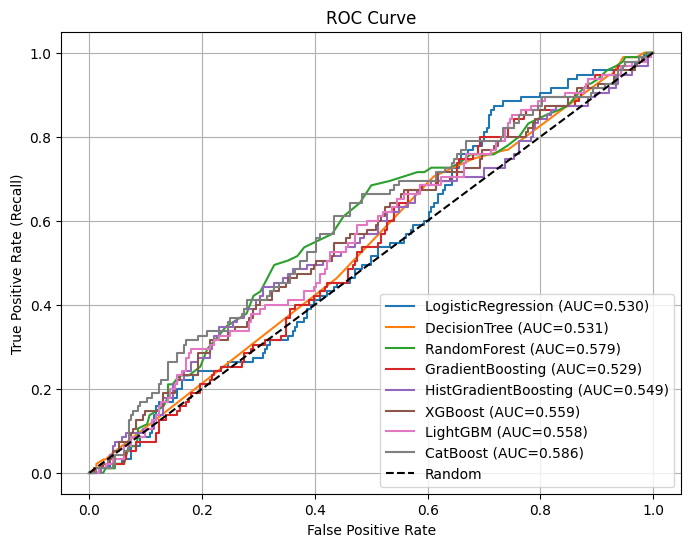

In [8]:
# -----------------------------
# ROC Curve 시각화
# -----------------------------
plt.figure(figsize=(8, 6))
for name, (fpr, tpr, auc) in roc_data.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

- 전체적으로 망한여행 클래스 recall, f1-score도 개선됨
- LogisticRegression : Recall 0.54 크게 개선 / Accuracy 0.50까지 하락 (클래스 밸런스를 강제한 효과) → 그래도 예측엔 성능 부족
- DecisionTree : Recall 0.75 클래스 1 거의 탐지, 0 클래스 Precision 급격히 하락 → Accuracy 0.44 → 과적합/불안정 가능성
- RandomForest / GradientBoosting : 여전히 1 클래스 탐지 거의 못함 → 불균형 처리 효과 미미
- HistGradientBoosting : Recall 0.48 / Precision 0.33 / F1=0.39 → 균형측면에서는 가장 양호, ROC-AUC 0.55
- XGBoost : Recall 0.41, Precision 0.34, F1=0.37 → 안정적 / ROC-AUC 0.559 → 분류 경계선 개선..
- LightGBM : Recall 0.53 → XGB보다 높은 탐지율 / F1=0.39 → HistGradientBoosting와 같이 가장 균형 잡힘
- CatBoost : Recall 0.41, Precision 0.34 → XGB와 유사, ROC-AUC 0.586 → 가장 높은 AUC

핵심 모델 후보 선정
- CatBoost: ROC-AUC 최고, Recall/Precision 밸런스 양호
- LightGBM: Recall 가장 높음 (0.53) → "망한 여행" 놓치는 비율 가장 적음
- HistGradientBoosting / XGBoost: 성능 비슷

In [9]:
# LightGBM, XGBoost, CatBoost, HistGradientBoosting